In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots;

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 500
quadrature_order       = 5
ϵ                      = 5
t_initial              = minimum(Time)
t_end                  = t_initial+60     # parameter value corresponding to ϵ=0
scale                  = 1
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [5]:
T(x, param) = flow(interp_rhs, x, [t_initial, t_end + scale*param], p=UV,
        tolerance=solver_tolerance,solver=solver)[end]

T (generic function with 1 method)

In [6]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [7]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [8]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

393.751265 seconds (324.88 M allocations: 19.220 GiB, 0.81% gc time)


In [9]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata);

In [10]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

5511.468007 seconds (500.75 M allocations: 48.024 GiB, 0.11% gc time)


In [11]:
# solve the linear system
@time λ₀s, u₀s = eigs(K, M, which=:SM)
@assert all(imag.(u₀s) .== 0)
@assert all(imag.(λ₀s) .== 0)
u₀s = real.(u₀s)
λ₀s = real.(λ₀s)
# normalize
for i in 1:size(u₀s)[2]
    u₀s[:,i] = u₀s[:,i] ./ sqrt(u₀s[:,i]'*M*u₀s[:,i])
    u₀s[:,i] = u₀s[:,i]*sign(sum(u₀s[:,i]))
end

  5.623034 seconds (9.20 M allocations: 1.102 GiB, 2.14% gc time)


In [12]:
# calculate the exact uϵ
λϵs, uϵs = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵs) .== 0)
@assert all(imag.(λϵs) .== 0)
uϵs = real.(uϵs)
λϵs = real.(λϵs)
# normalize
for i in 1:size(uϵs)[2]
    uϵs[:,i] = uϵs[:,i] ./ sqrt(uϵs[:,i]'*M*uϵs[:,i])
    uϵs[:,i] = uϵs[:,i]*sign(sum(uϵs[:,i]))
end

In [13]:
# solve the system for the derivative u_dot
u_dots = []
λ_dots = []
for i in 1:size(u₀s)[2] 
    lhs = [K-λ₀s[i]*M   -M*u₀s[:,i]
            u₀s[:,i]'*M      0]
    rhs = [-L*u₀s[:,i]    ;  0]

    @time b = lhs \ rhs
    push!(u_dots,b[1:end-1])
    push!(λ_dots,b[end])
end

 12.539949 seconds (2.38 M allocations: 2.718 GiB, 0.61% gc time)
 11.683863 seconds (78 allocations: 2.606 GiB, 1.31% gc time)
  4.115650 seconds (75 allocations: 364.317 MiB)
 11.665913 seconds (80 allocations: 2.606 GiB, 3.32% gc time)
 11.452915 seconds (78 allocations: 2.606 GiB, 0.48% gc time)
 11.354312 seconds (78 allocations: 2.698 GiB, 0.08% gc time)


In [22]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmin =     -1
cmax =     1
cmin_lr =  -0.15
cmax_lr =  0.15

0.15

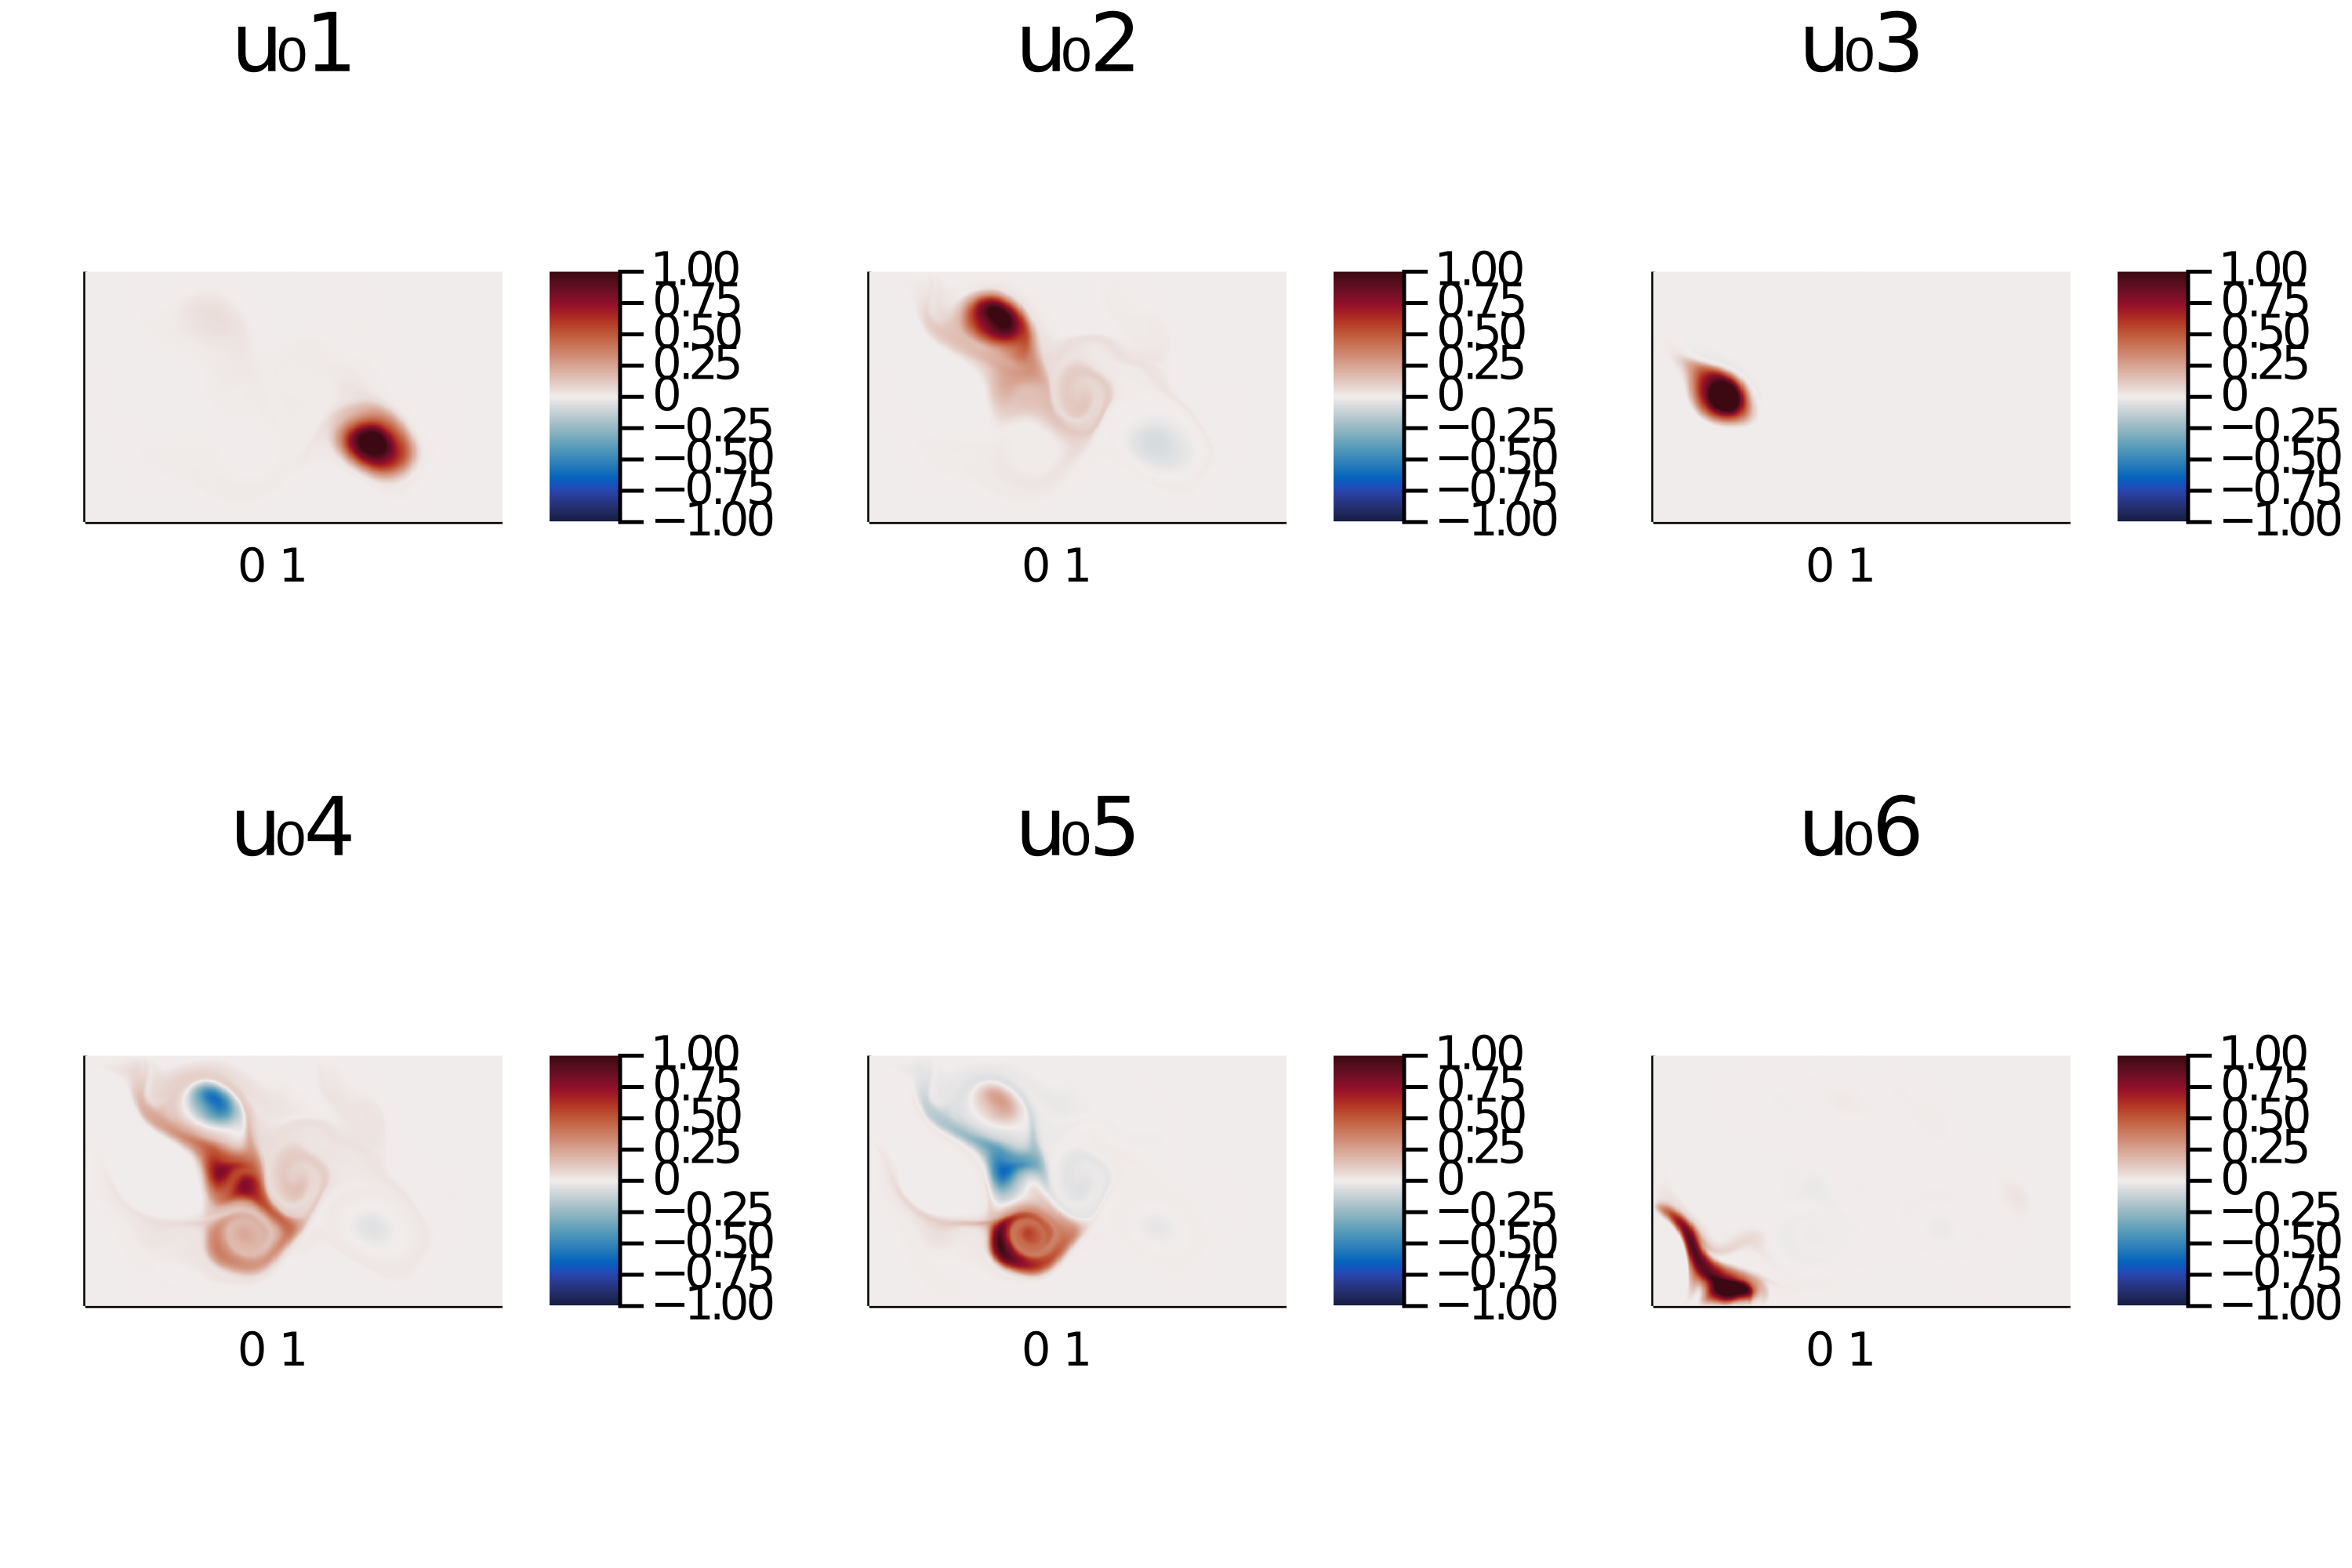

In [23]:
first         = plot_u(ctx, u₀s[:,1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, u₀s[:,2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, u₀s[:,3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, u₀s[:,4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, u₀s[:,5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, u₀s[:,6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

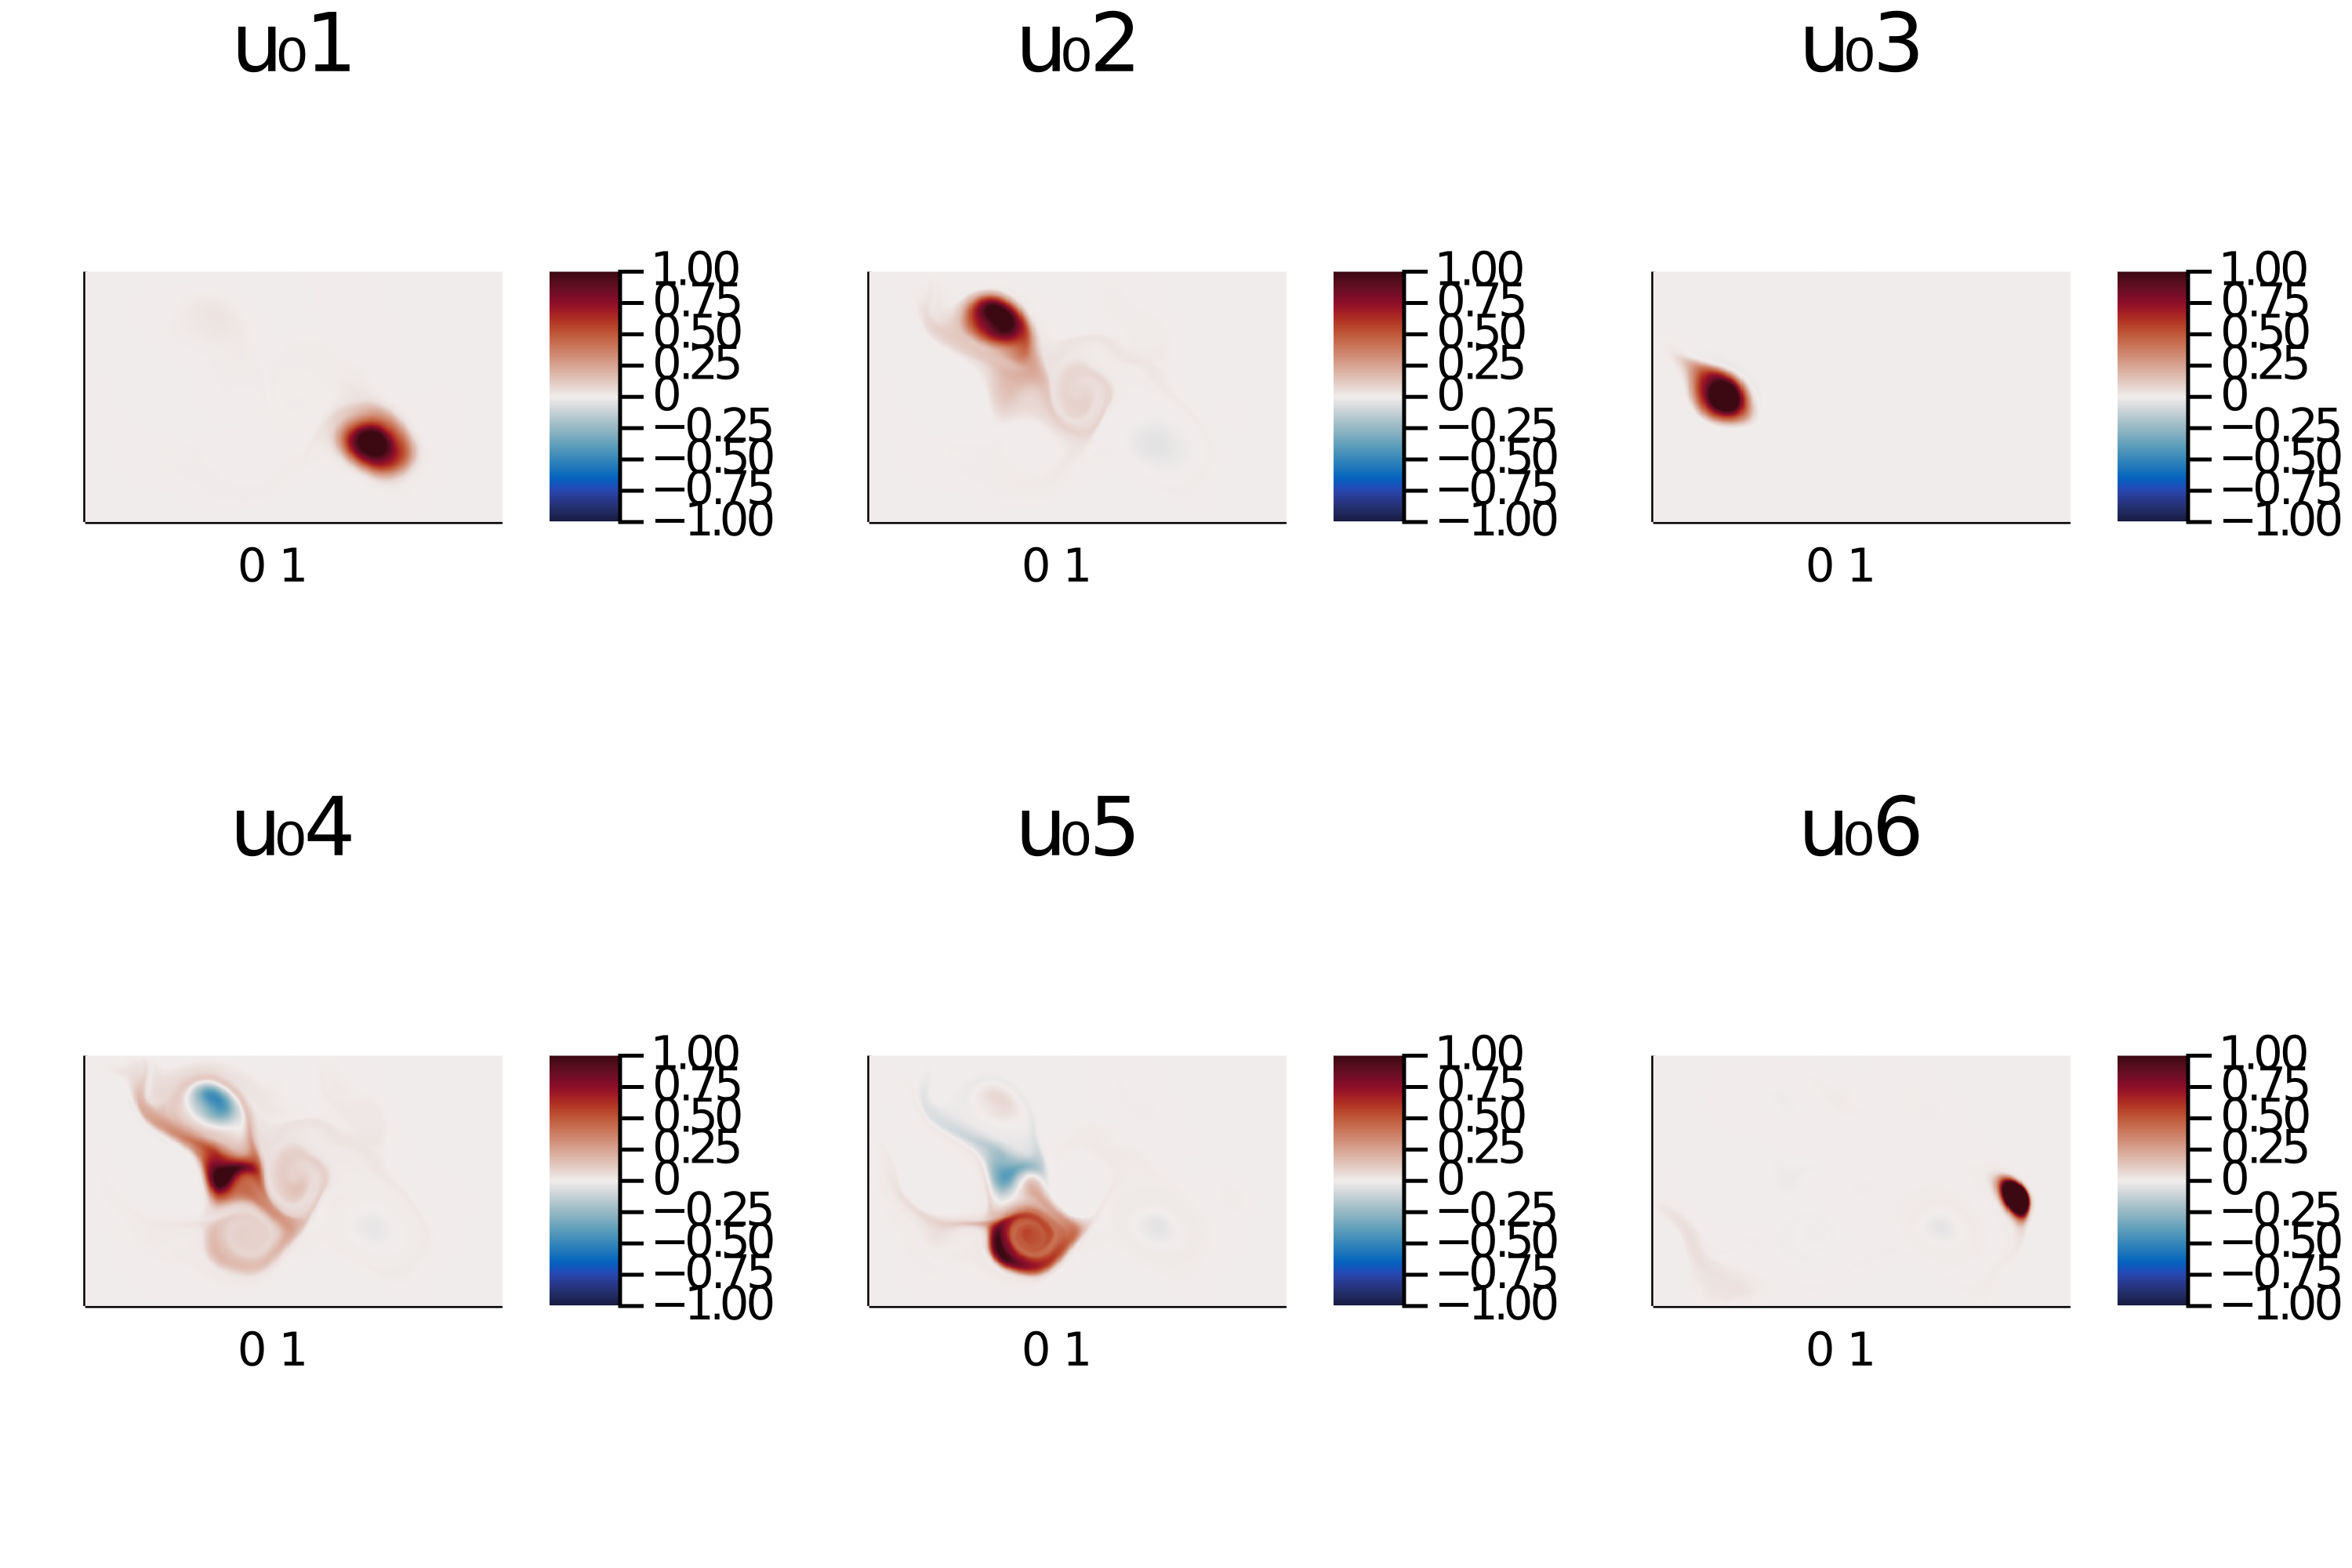

In [25]:
first         = plot_u(ctx, uϵs[:,1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, uϵs[:,2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, uϵs[:,3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, uϵs[:,4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, uϵs[:,5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, uϵs[:,6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

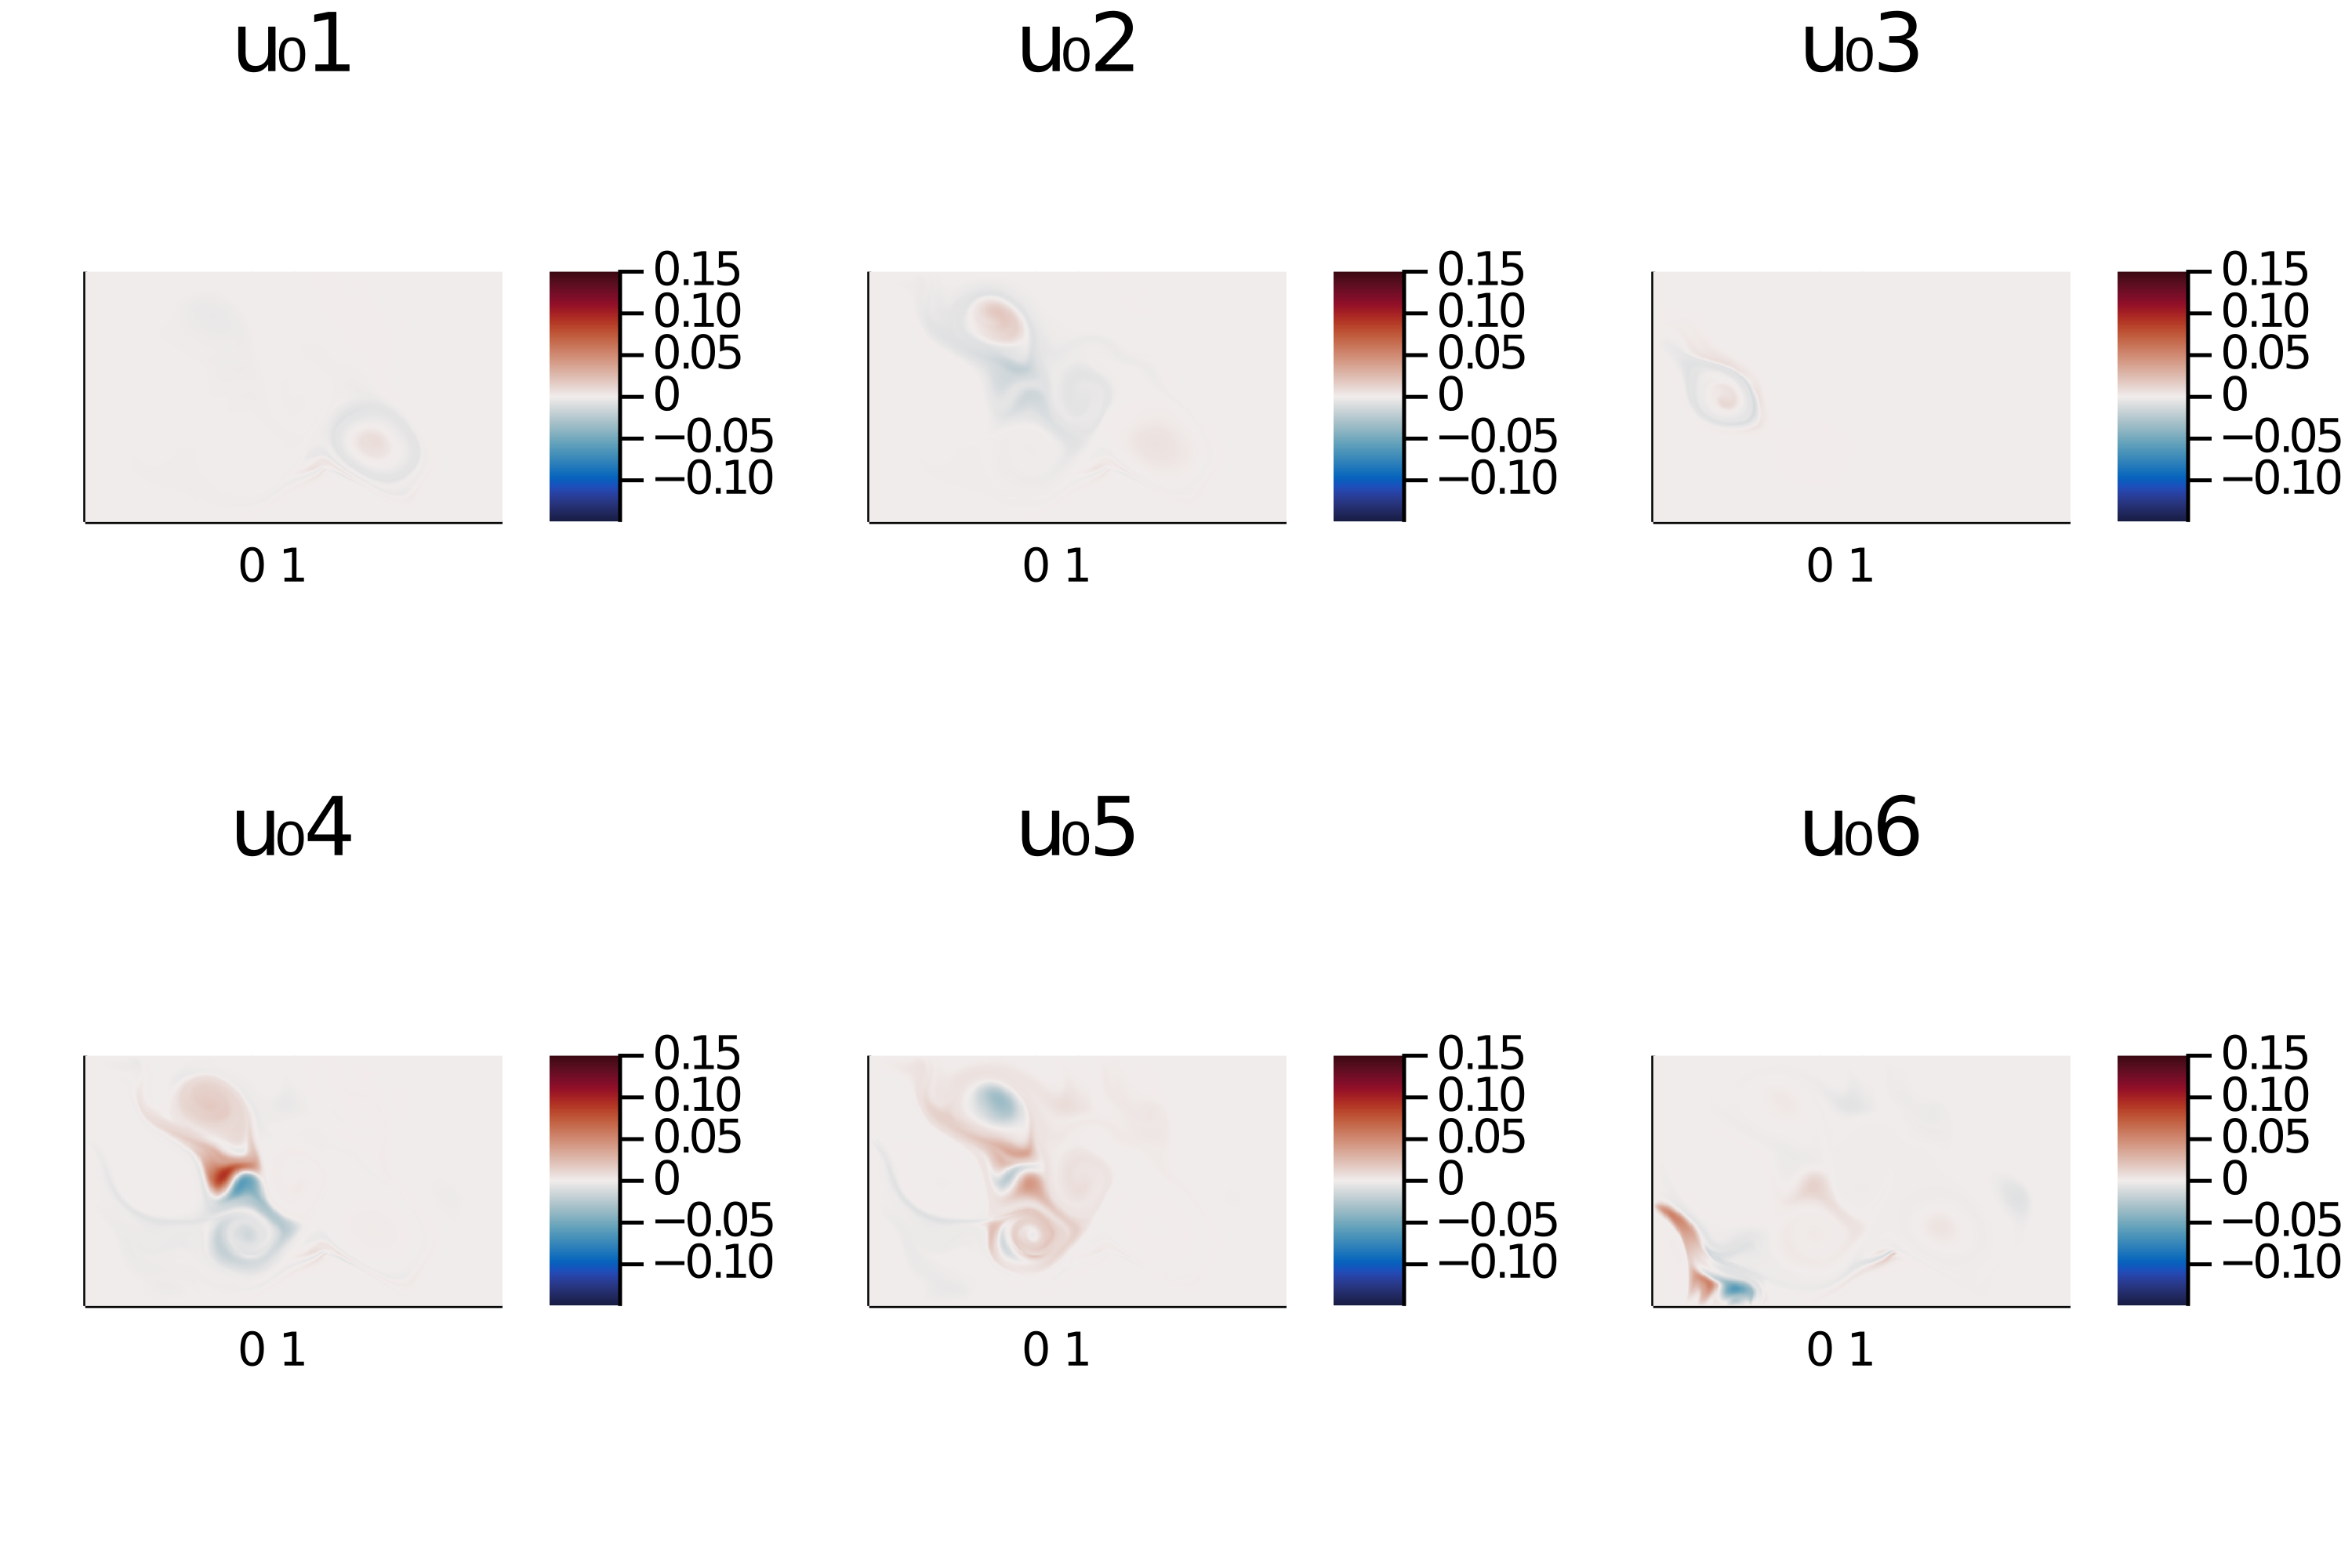

In [26]:
first         = plot_u(ctx, u_dots[1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, u_dots[2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, u_dots[3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, u_dots[4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, u_dots[5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, u_dots[6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

In [18]:
S = SEBA(u₀s)

148404×6 Array{Float64,2}:
 0.0  0.0  -0.0  -0.0  0.0  0.0
 0.0  0.0  -0.0  -0.0  0.0  0.0
 0.0  0.0  -0.0  -0.0  0.0  0.0
 0.0  0.0  -0.0  -0.0  0.0  0.0
 0.0  0.0  -0.0  -0.0  0.0  0.0
 0.0  0.0  -0.0  -0.0  0.0  0.0
 0.0  0.0  -0.0  -0.0  0.0  0.0
 0.0  0.0  -0.0  -0.0  0.0  0.0
 0.0  0.0  -0.0  -0.0  0.0  0.0
 0.0  0.0  -0.0  -0.0  0.0  0.0
 0.0  0.0  -0.0  -0.0  0.0  0.0
 0.0  0.0  -0.0  -0.0  0.0  0.0
 0.0  0.0  -0.0  -0.0  0.0  0.0
 ⋮                          ⋮
 0.0  0.0  -0.0   0.0  0.0  0.0
 0.0  0.0  -0.0   0.0  0.0  0.0
 0.0  0.0  -0.0   0.0  0.0  0.0
 0.0  0.0  -0.0   0.0  0.0  0.0
 0.0  0.0  -0.0   0.0  0.0  0.0
 0.0  0.0  -0.0   0.0  0.0  0.0
 0.0  0.0  -0.0   0.0  0.0  0.0
 0.0  0.0  -0.0   0.0  0.0  0.0
 0.0  0.0  -0.0   0.0  0.0  0.0
 0.0  0.0  -0.0   0.0  0.0  0.0
 0.0  0.0  -0.0   0.0  0.0  0.0
 0.0  0.0  -0.0   0.0  0.0  0.0

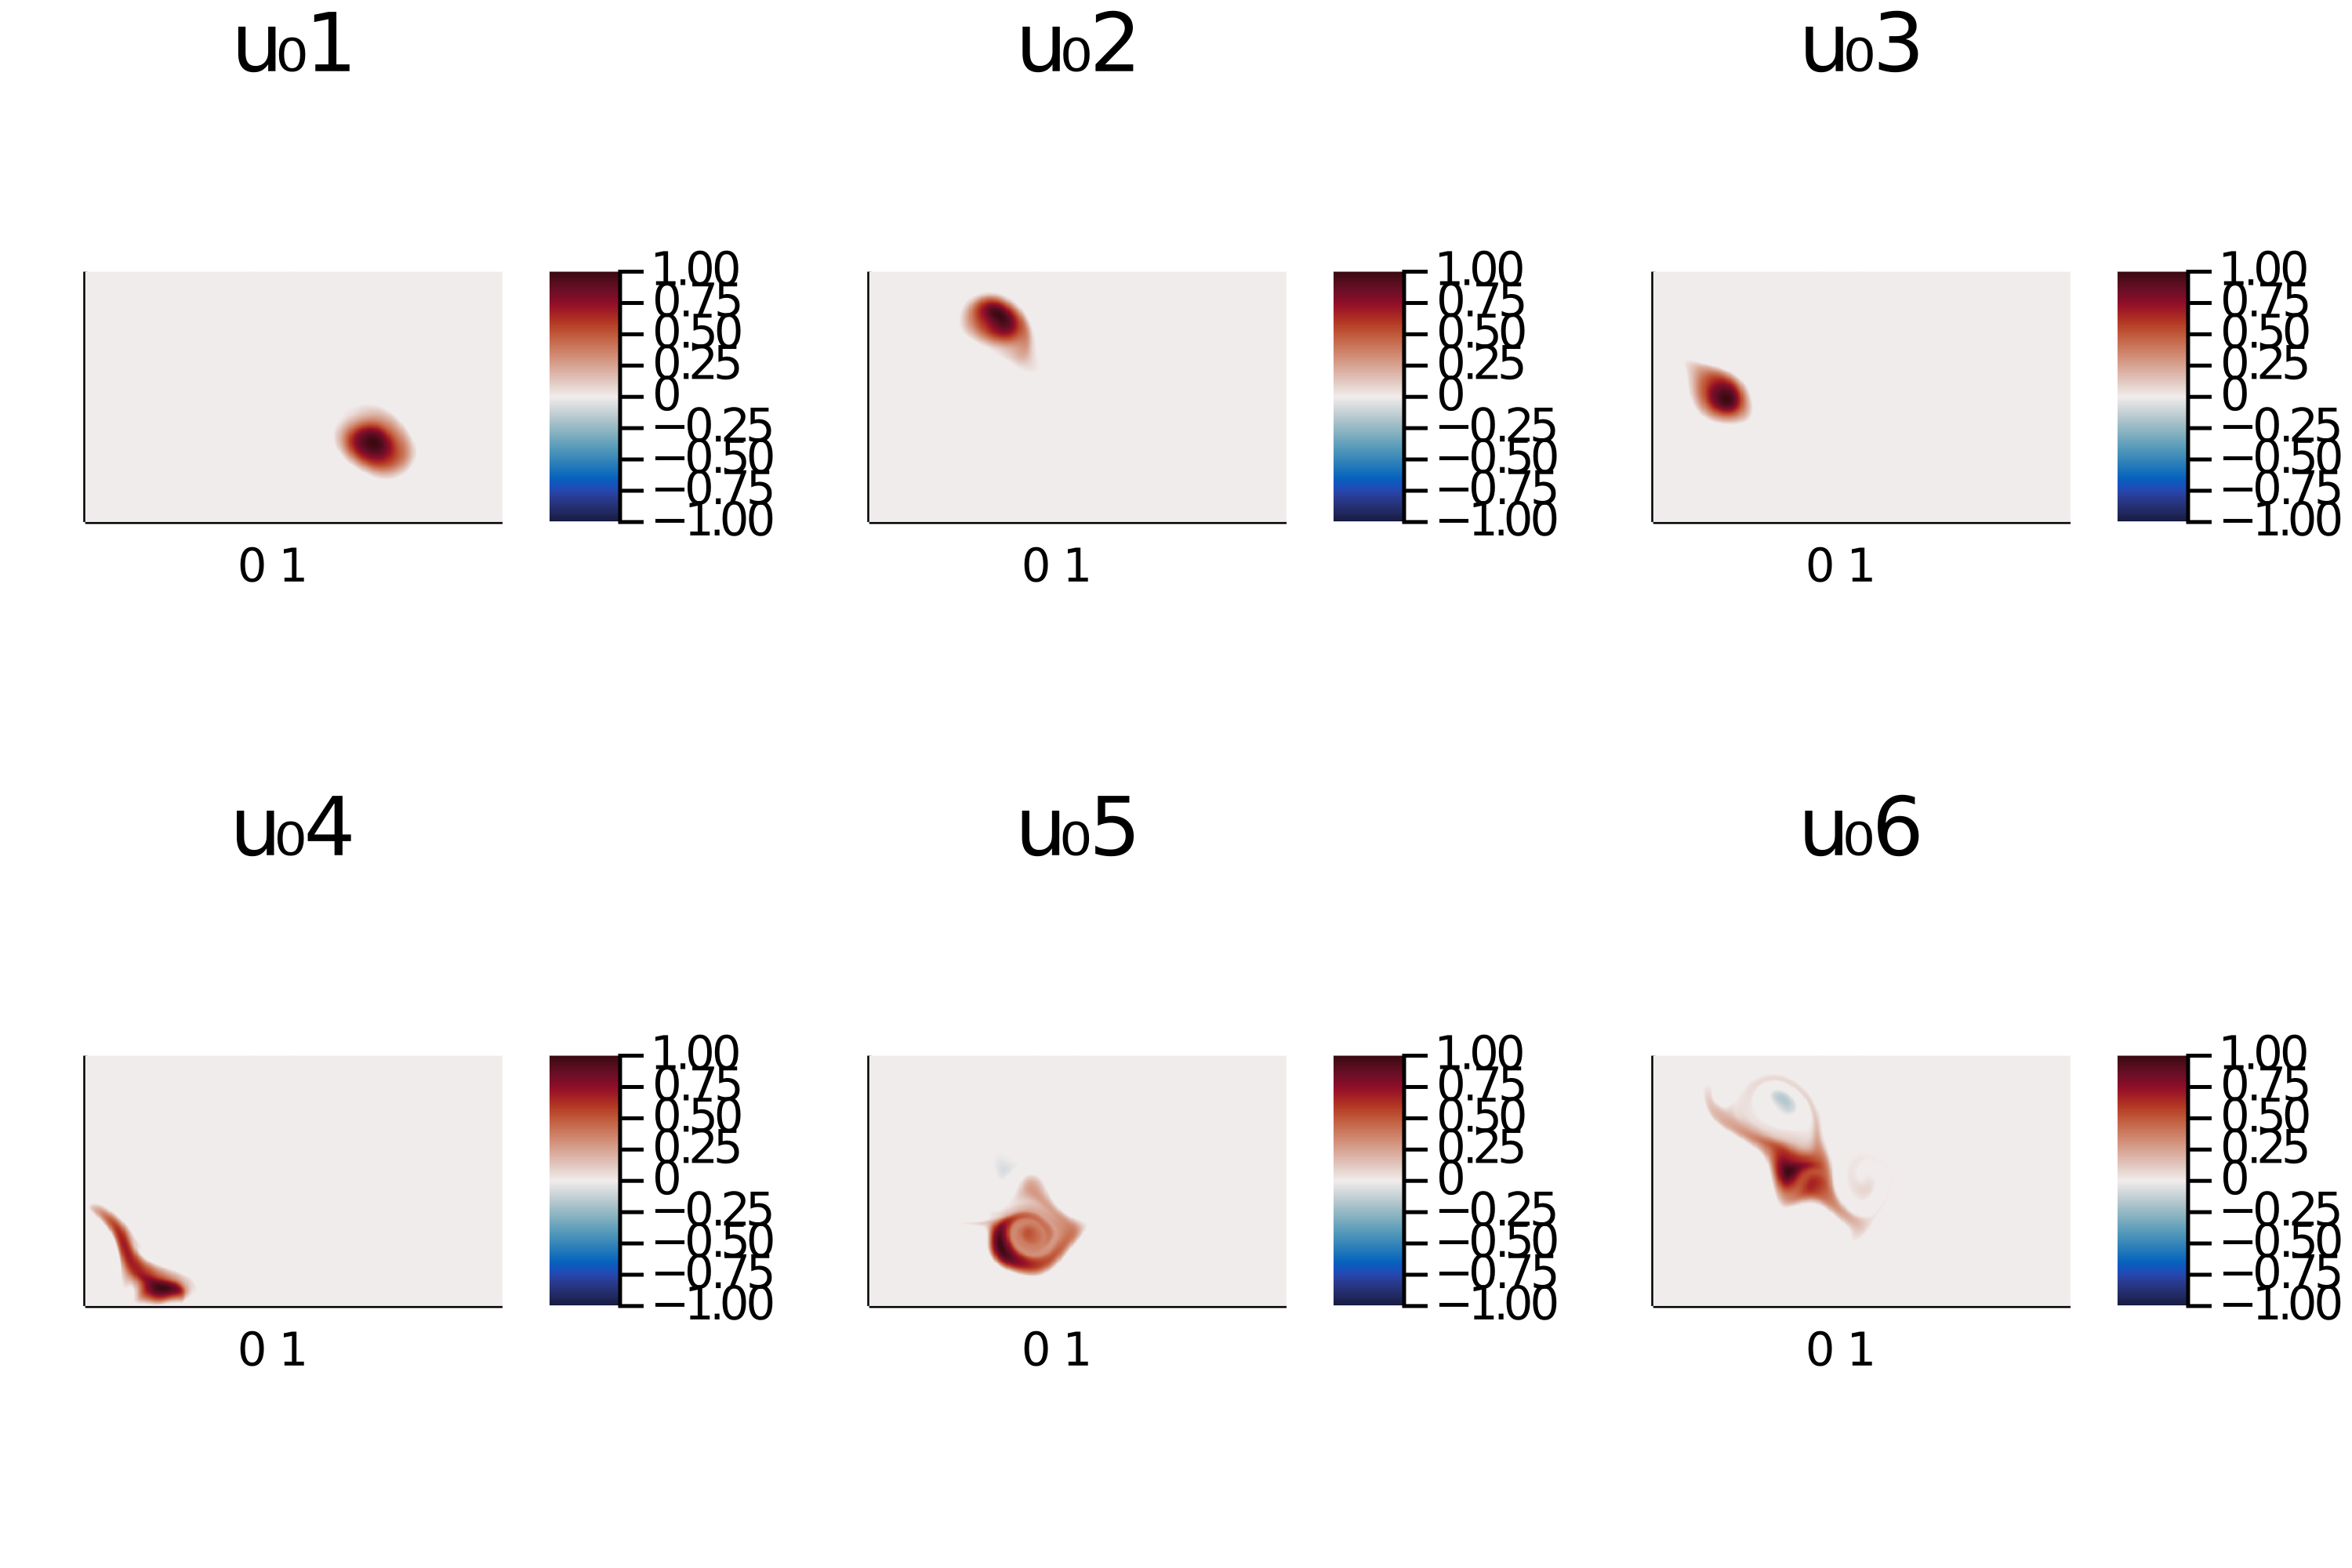

In [27]:
first         = plot_u(ctx, S[:,1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, S[:,2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, S[:,3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, S[:,4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, S[:,5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, S[:,6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

In [20]:
Sϵ = SEBA(uϵs)

148404×6 Array{Float64,2}:
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
 -0.0   0.0  0.0  -0.0  -0.0  -0.0
  ⋮                            ⋮
 -0.0  -0.0  0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  0.0  -0.0  -0.0  -0.0

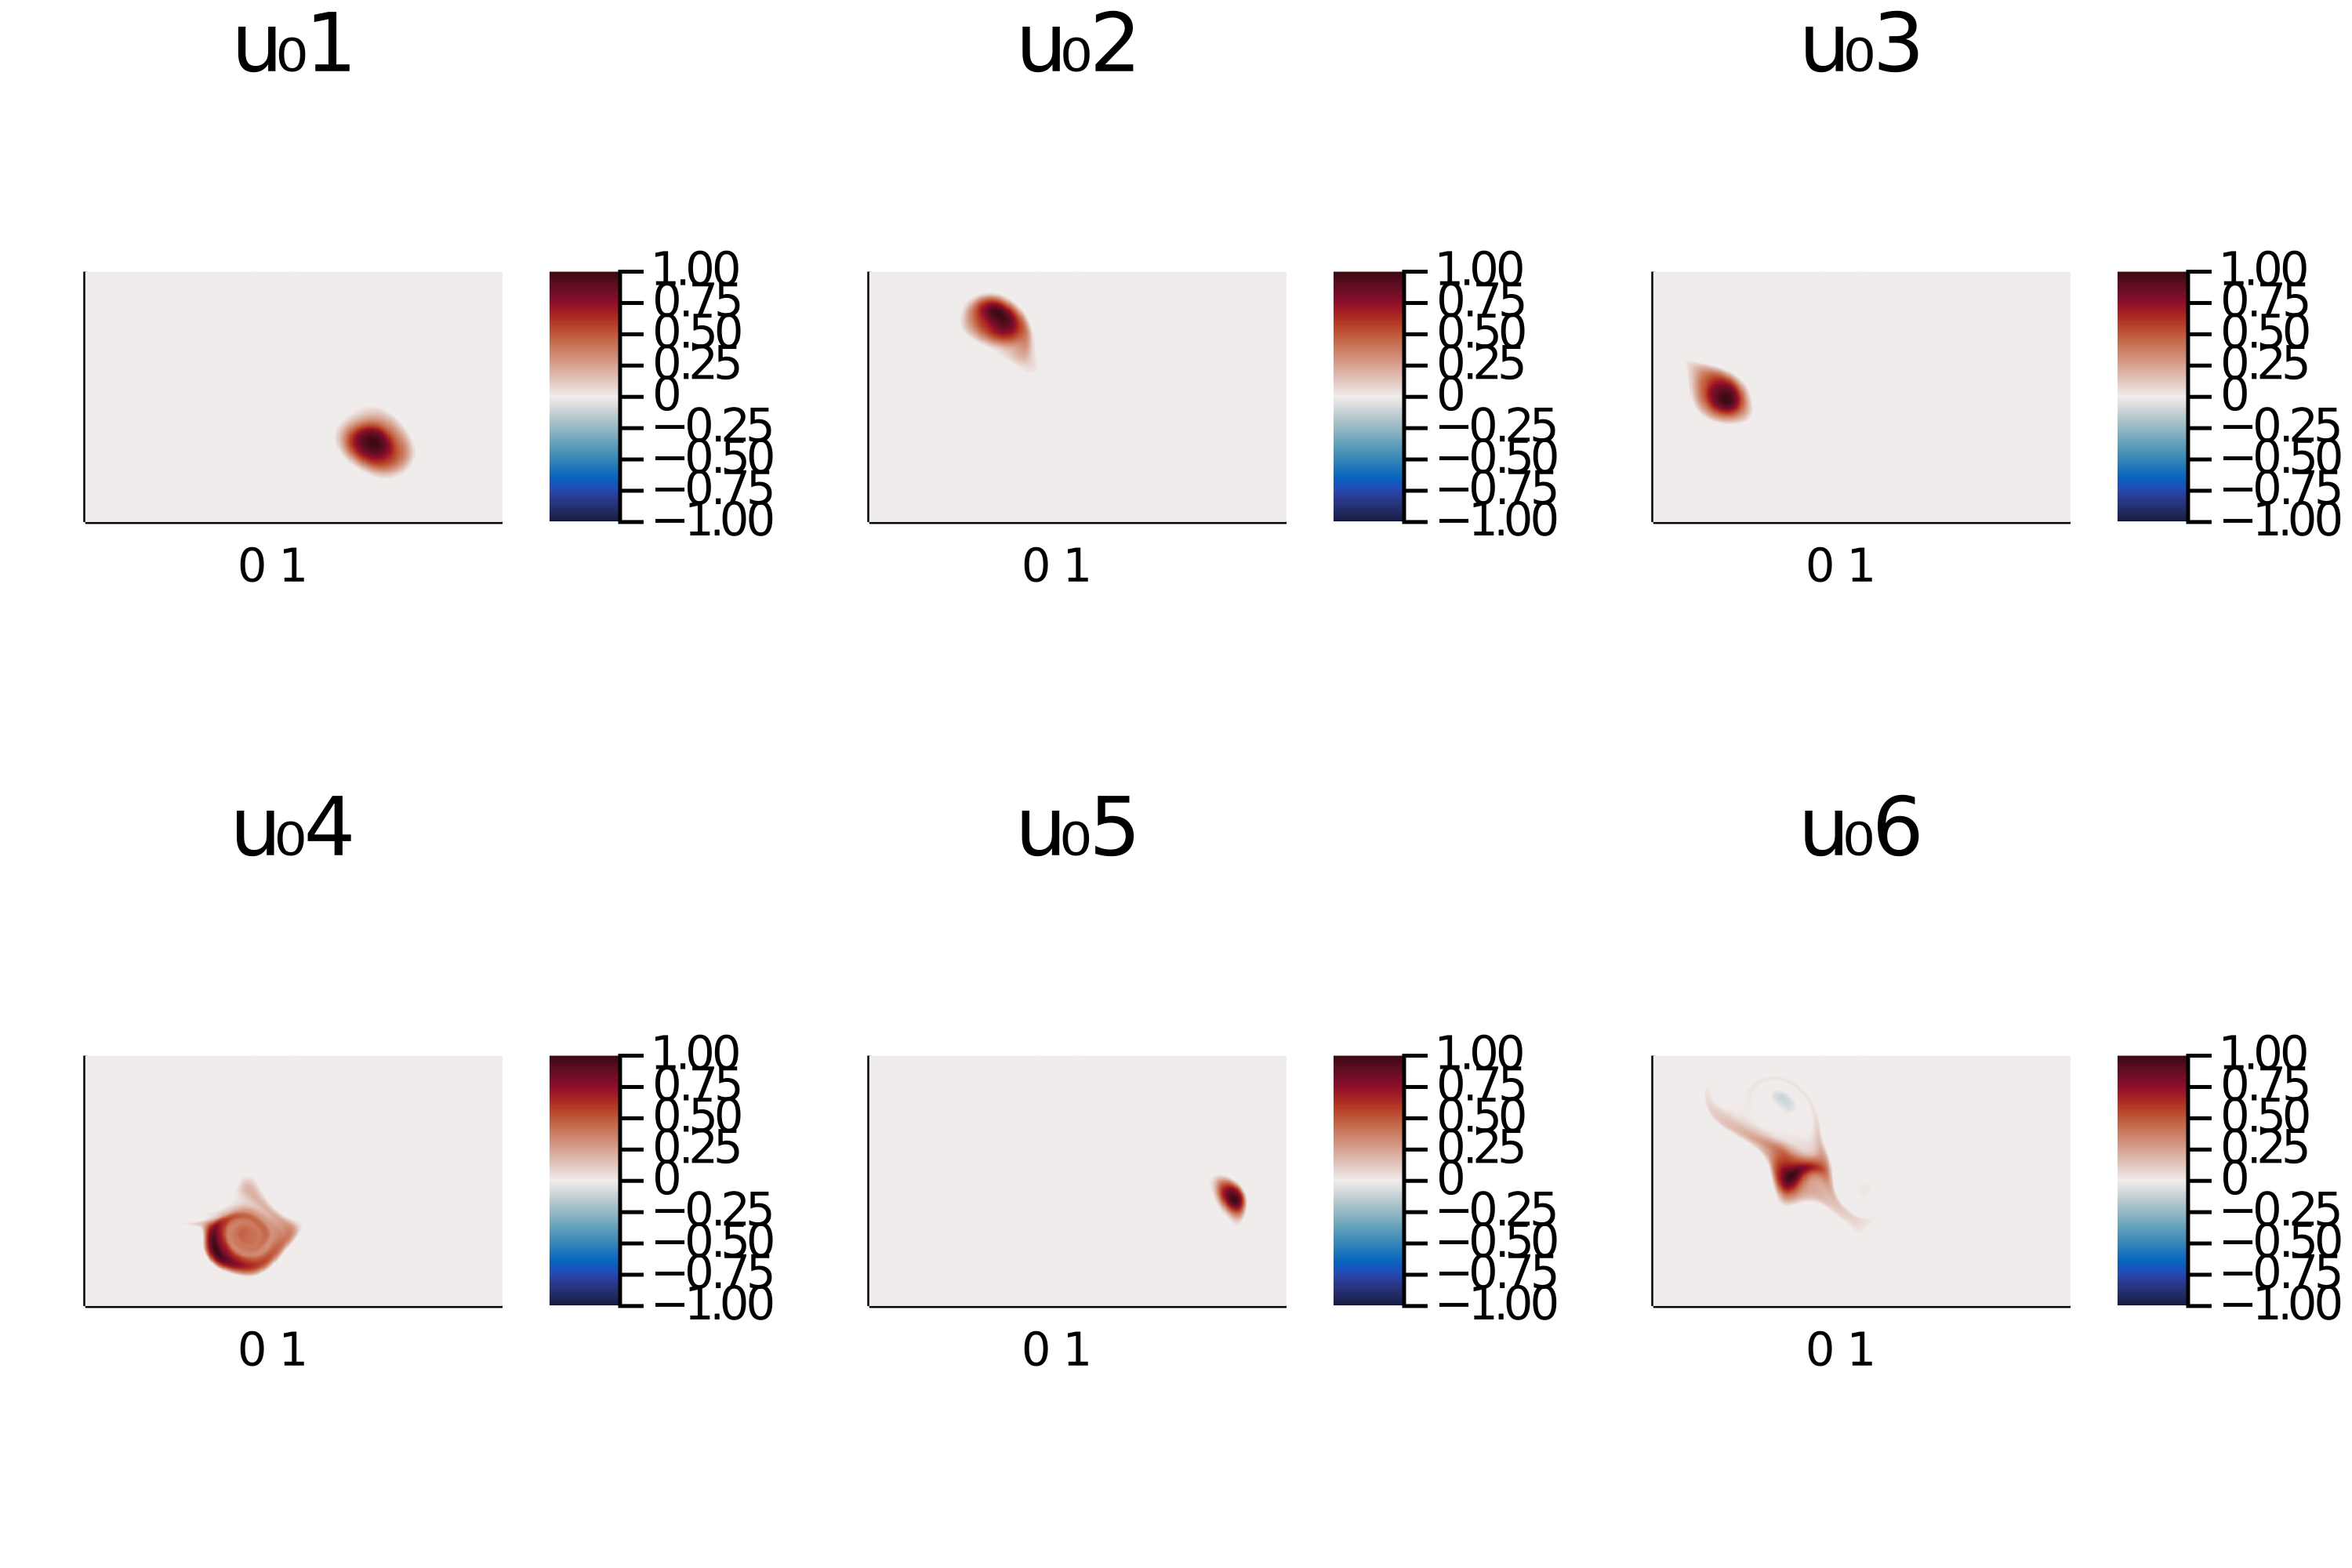

In [28]:
first         = plot_u(ctx, Sϵ[:,1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, Sϵ[:,2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, Sϵ[:,3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, Sϵ[:,4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, Sϵ[:,5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, Sϵ[:,6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)